In [4]:
import pandas as pd
import time
from datetime import datetime
import geopandas as gpd
import shapely
import numpy as np

In [5]:
def VBOCleaner(data):
    from shapely.geometry import asPoint    
    # only keep objects with id
    data = data[data["identificatie"].notna()]    
    # only keep objects which are currently in use # CHECK of dit de juiste zijn
    data = data[data.verblijfsobjectStatus.isin(["Verblijfsobject gevormd", 
                                                 "Verblijfsobject in gebruik",
                                                 "Verblijfsobject in gebruik (niet ingemeten)"])]
    data = data[data.pos.notna()]    
    data["begindatumTijdvakGeldigheid"] =  pd.to_datetime(data['begindatumTijdvakGeldigheid'], format='%Y%m%d%H%M%S%f', errors='coerce')
    data["einddatumTijdvakGeldigheid"] =  pd.to_datetime(data['einddatumTijdvakGeldigheid'], format='%Y%m%d%H%M%S%f', errors='coerce')
    
    def toPoint(pos):
        string = "POINT " + str([float(i) for i in pos.split()[:2]])
        return string.replace("[", "(").replace("]", ")").replace(",", "")
    data.pos = data.pos.apply(toPoint)
    
    return data

In [44]:
def snapshotter(vbo, grid_vbo, year):
    d1 = datetime(year, 1, 1)
    vbo = vbo[vbo["begindatumTijdvakGeldigheid"] < d1]
    vbo = vbo[(vbo["einddatumTijdvakGeldigheid"] > d1) | (vbo["einddatumTijdvakGeldigheid"].isna())]

    print(sum(vbo.gebruiksdoelVerblijfsobject == "woonfunctie"))
    
    
    data = grid_vbo.merge(vbo, how = "left", right_on = ["identificatie","pos"], left_on = ["identificatie","pos"])
    print(sum(data.gebruiksdoelVerblijfsobject == "woonfunctie"))
    
    data = data.join(pd.get_dummies(data.gebruiksdoelVerblijfsobject))
    data = data.drop("gebruiksdoelVerblijfsobject", axis = 1)
    data = data.groupby("C28992R100").agg({
        "bijeenkomstfunctie" : "sum",
        "celfunctie" : "sum",
        "gezondheidszorgfunctie" : "sum",
        "industriefunctie" : "sum",
        "kantoorfunctie" : "sum",
        "logiesfunctie" : "sum",
        "onderwijsfunctie" : "sum",
        "sportfunctie" : "sum",
        "winkelfunctie" : "sum",
        "woonfunctie" : "sum",
        "oppervlakteVerblijfsobject" : "median"
    })
    
    return data

In [7]:
## TODO: find out about bad lines
VBO = pd.read_csv("VBO.csv", sep = ";", encoding = "utf-8", na_values = "NaN", on_bad_lines = "warn")
VBO = VBOCleaner(VBO)

# eindhoven vbo links eindhoven grids to vbos
grid_vbo = pd.read_csv("eindhoven_vbo.csv")[["identificatie","C28992R100","pos"]]
grid_vbo = grid_vbo.drop_duplicates()

# This is the full grid of eindhoven, necessary since not all grids have a vbo
grid_full = pd.read_csv("Eindhoven_grid.csv")
grid_full = grid_full[["rep_id", "cbs_100","lb_gridcod", "geometry"]]
grid_full.geometry = grid_full.geometry.apply(shapely.wkt.loads)
grid_full = grid_full.set_index("cbs_100")



POINT (157258.155 389575.087)
POINT (157237.111 389522.894)
POINT (155198.641 392232.817)
POINT (155813.834 388712.351)
POINT (155813.834 388712.351)
POINT (154773.621 390013.126)
POINT (155337.279 389700.026)
POINT (155384.082 389762.257)
POINT (155393.218 389787.087)
POINT (155377.799 389762.088)
POINT (155390.101 389787.201)
POINT (155384.891 389786.859)
POINT (155381.358 389786.763)
POINT (155378.269 389786.876)
POINT (155374.871 389786.784)
POINT (155367.84 389794.865)
POINT (155364.799 389702.56)
POINT (155364.182 389708.973)
POINT (155363.601 389715.015)
POINT (155432.293 390499.31)
POINT (155220.285 390287.045)
POINT (155361.795 389733.818)
POINT (155359.89 389742.89)
POINT (155359.276 389749.181)
POINT (155359.276 389749.181)
POINT (155358.653 389755.564)
POINT (155358.027 389761.973)
POINT (155329.773 389788.565)
POINT (155324.014 389787.99)
POINT (155318.333 389784.937)
POINT (155312.367 389784.352)
POINT (155306.199 389783.748)
POINT (155300.649 389783.204)
POINT (155331.14

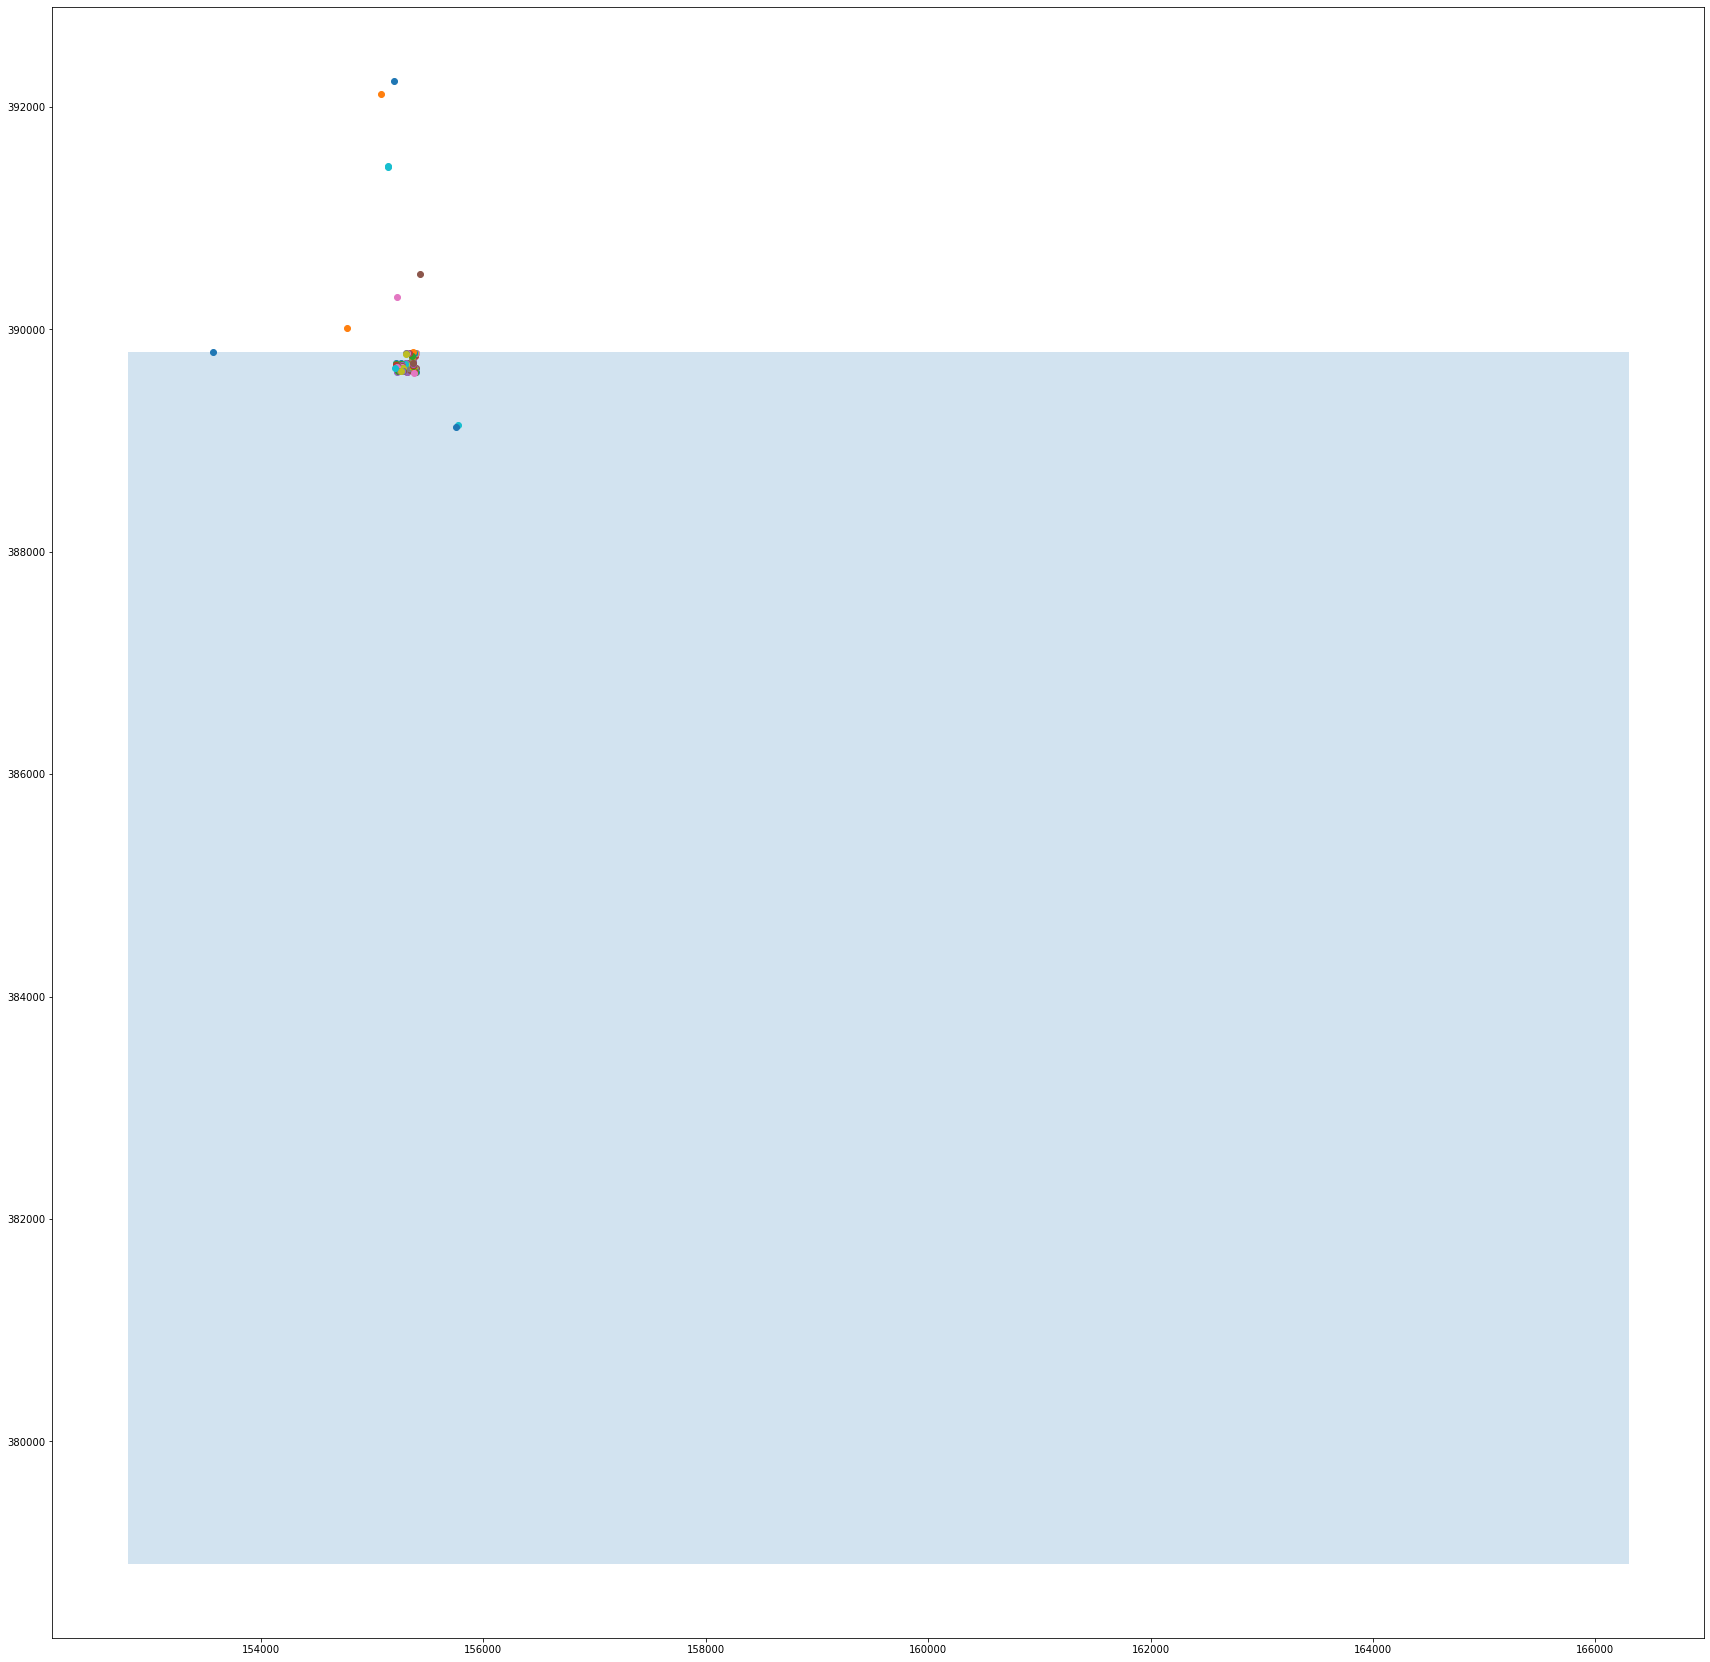

In [183]:
grid.plot(alpha = 0.2, figsize = (30,30))
count = 0
counta = 0
for _, i in test.iterrows():
    print(i.pos)
    x,y = i.pos.xy
    if  x[0] < 155800 and x[0] > 14000:
        counta += 1
        plt.scatter(*i.pos.xy)
        if counta >100:
            break
    else:
        count += 1
        
print(count, counta)
plt.show()

In [78]:
data2015 = snapshotter(VBO, grid_vbo, 2015)
data2016 = snapshotter(VBO, grid_vbo, 2016)
data2017 = snapshotter(VBO, grid_vbo, 2017)
data2018 = snapshotter(VBO, grid_vbo, 2018)
data2019 = snapshotter(VBO, grid_vbo, 2019)
data2020 = snapshotter(VBO, grid_vbo, 2020)

7579498
131167
7648521
134731
7706489
135954
7782031
138238
7875174
140966
7943656
143601


In [79]:
data2015["y"] = (data2015.woonfunctie < data2016.woonfunctie).astype(int)
data2016["y"] = (data2016.woonfunctie < data2017.woonfunctie).astype(int)
data2017["y"] = (data2017.woonfunctie < data2018.woonfunctie).astype(int)
data2018["y"] = (data2018.woonfunctie < data2019.woonfunctie).astype(int)
data2019["y"] = (data2019.woonfunctie < data2020.woonfunctie).astype(int)

In [80]:
data2015 = grid_full.join(data2015, rsuffix = "r")
data2016 = grid_full.join(data2016, rsuffix = "r")
data2017 = grid_full.join(data2017, rsuffix = "r")
data2018 = grid_full.join(data2018, rsuffix = "r")
data2019 = grid_full.join(data2019, rsuffix = "r")

In [81]:
data2015 = gpd.GeoDataFrame(data2015)
data2016 = gpd.GeoDataFrame(data2016)
data2017 = gpd.GeoDataFrame(data2017)
data2018 = gpd.GeoDataFrame(data2018)
data2019 = gpd.GeoDataFrame(data2019)

<AxesSubplot:>

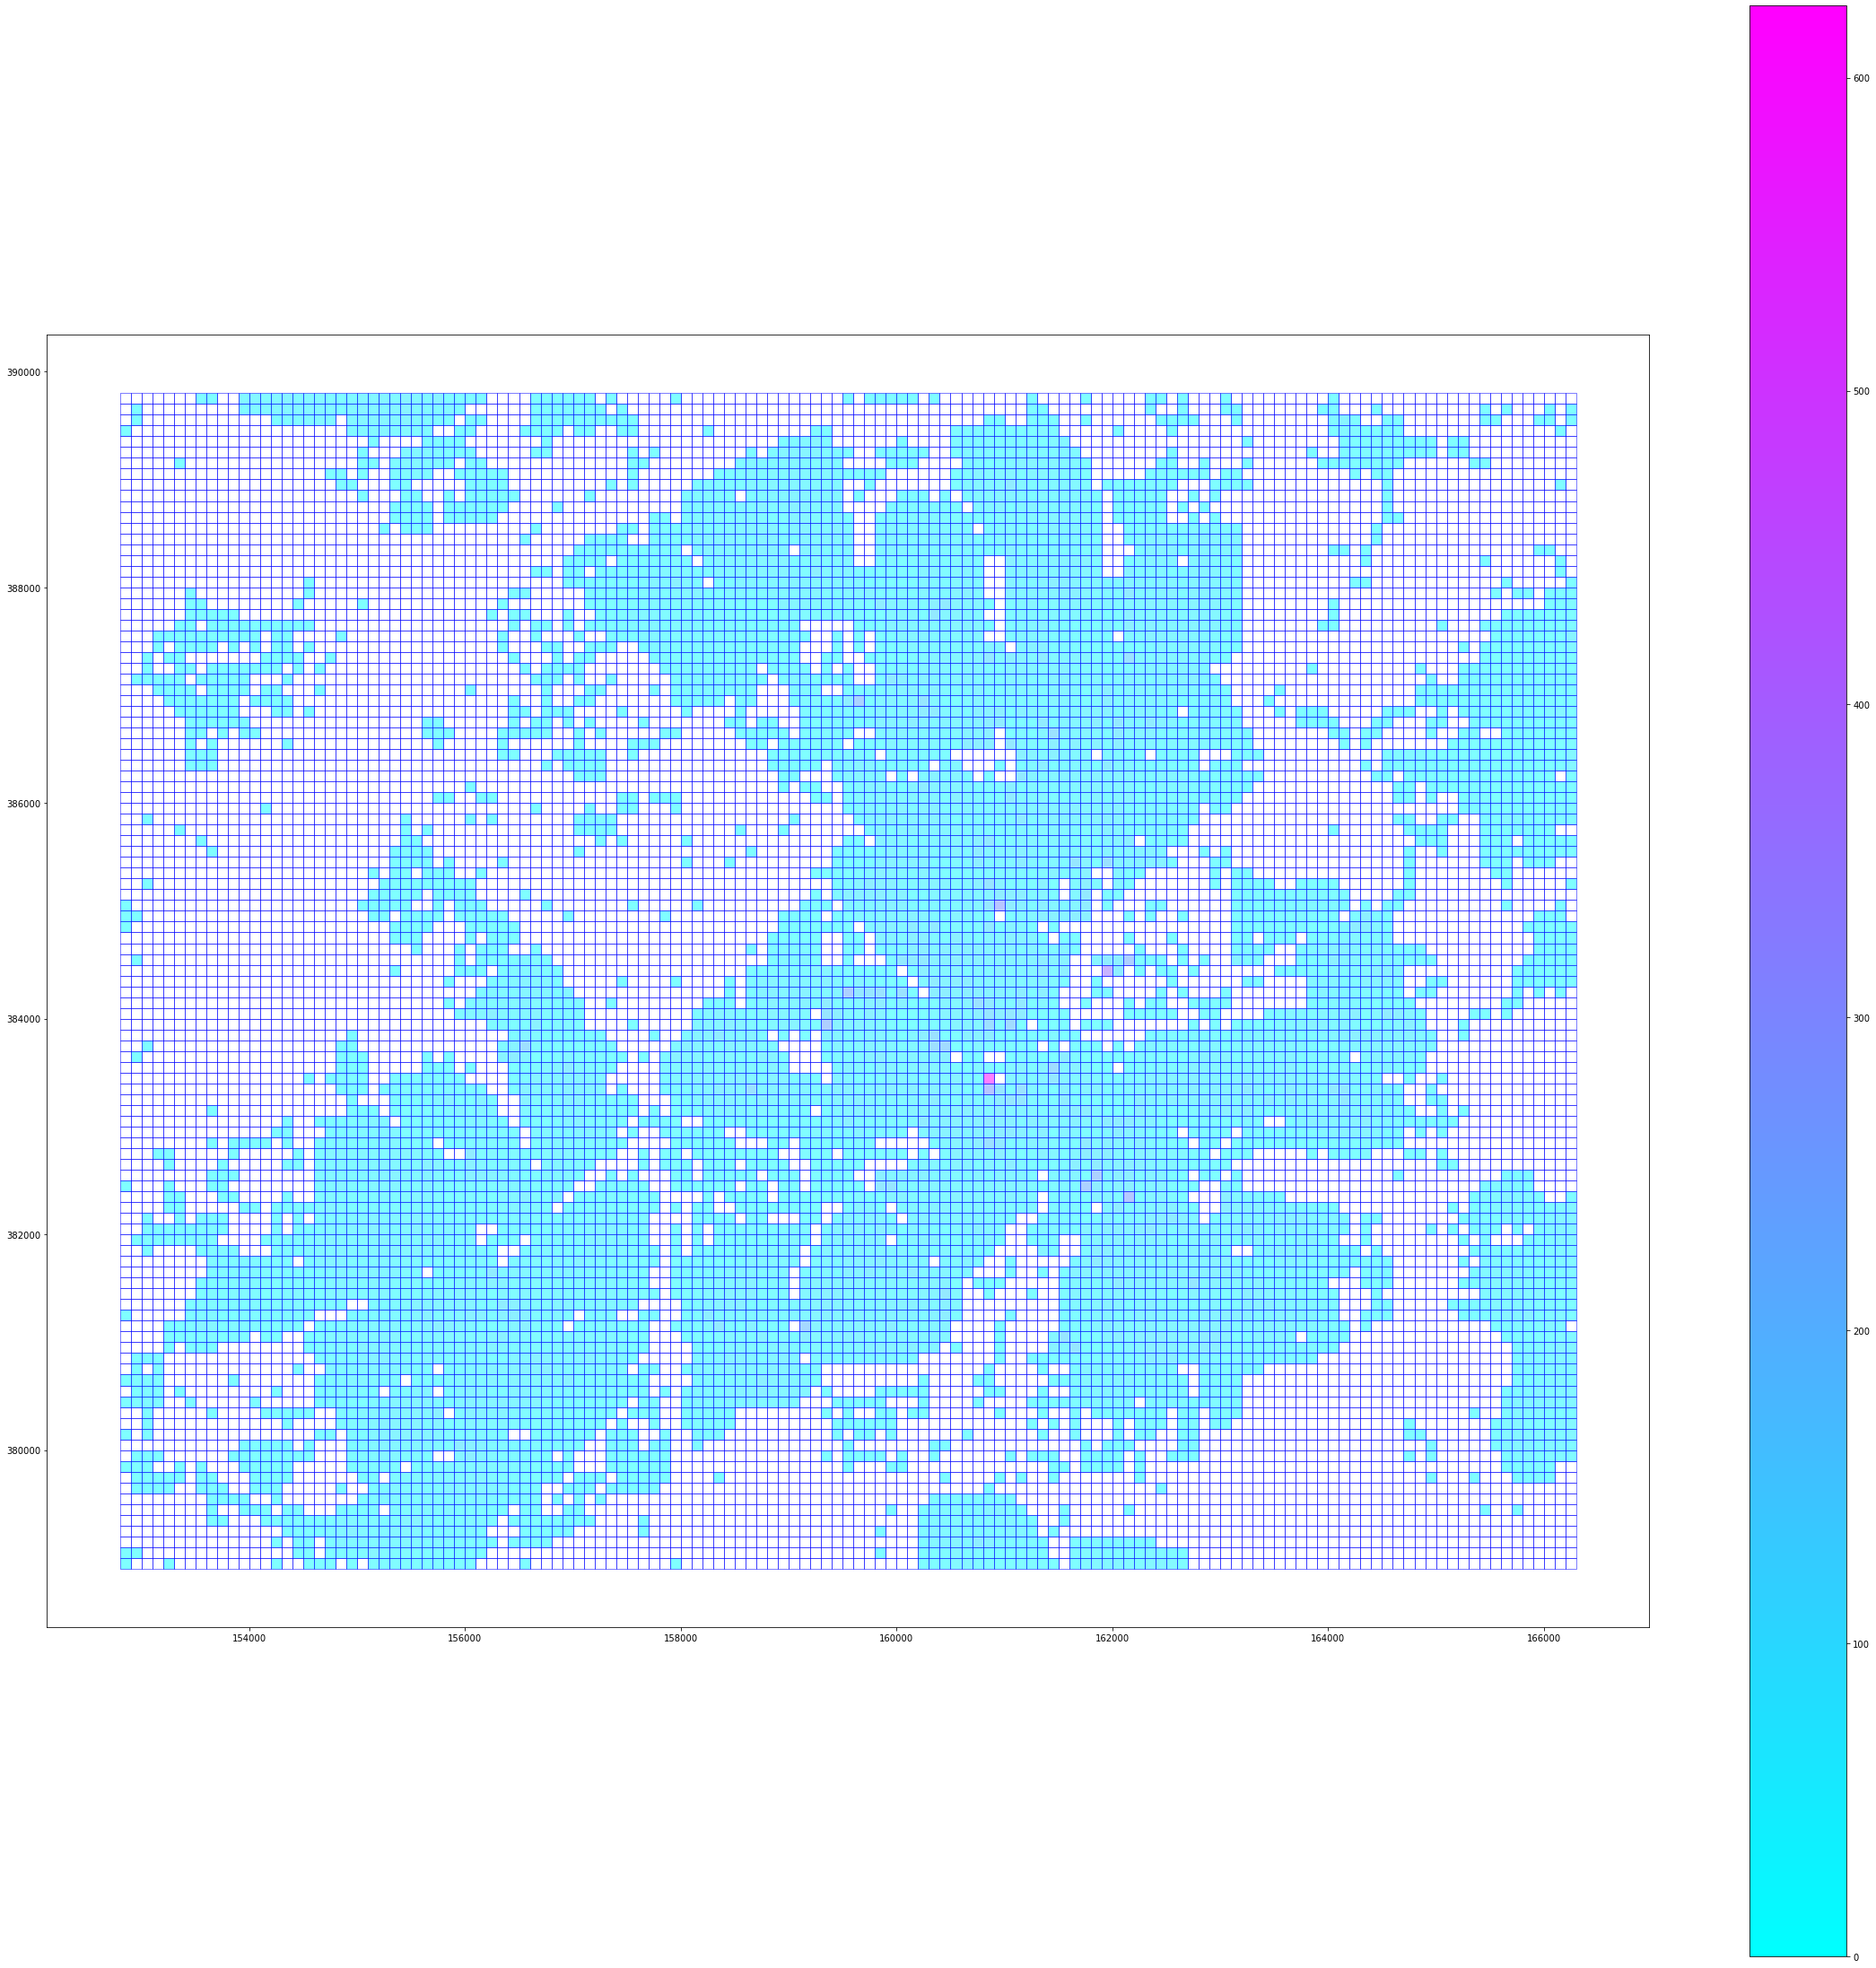

In [84]:
data2016.plot(figsize = (40,40), alpha=0.5, edgecolor = "b", column='woonfunctie',cmap='cool',legend=True)

In [141]:
grid2015.describe()

,bijeenkomstfunctie,celfunctie,gezondheidszorgfunctie,industriefunctie,kantoorfunctie,logiesfunctie,onderwijsfunctie,sportfunctie,winkelfunctie,woonfunctie,oppervlakteVerblijfsobject,y
count,7506.000000,7506.000000,7506.000000,7506.000000,7506.000000,7506.000000,7506.000000,7506.000000,7506.000000,7506.000000,6865.000000,7506.00000
mean,0.149347,0.000266,0.093925,0.308820,0.425127,0.028511,0.037037,0.024247,0.353983,17.474953,314.156883,0.06688
std,0.641200,0.016322,1.096951,0.958858,1.883001,0.413287,0.215861,0.166312,1.555308,20.478935,2122.900021,0.24983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,101.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,127.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.750000,171.000000,0.00000
max,18.000000,1.000000,58.000000,26.000000,77.000000,16.000000,5.000000,3.000000,50.000000,278.000000,151313.000000,1.00000


# add nabijheidsdata on buurt level to grid:


In [28]:
koppel = pd.read_csv("../Data/grids_koppeling_gwb.csv", sep = ";")
koppel = koppel.set_index("id_grid")
koppel = koppel["id_buurt"]

In [117]:
# load all cbs nabijheidsstatistieken
import cbsodata
cbs15 = pd.DataFrame(cbsodata.get_data('83304NED')).set_index("Codering_3")
cbs16 = pd.DataFrame(cbsodata.get_data('83749NED')).set_index("Codering_3")
cbs17 = pd.DataFrame(cbsodata.get_data('84334NED')).set_index("Codering_3")
cbs18 = pd.DataFrame(cbsodata.get_data('84463NED')).set_index("Codering_3")
cbs19 = pd.DataFrame(cbsodata.get_data('84718NED')).set_index("Codering_3")

In [118]:
# Only keep neighborhood related data (smallest area)
cbs15 = cbs15[cbs15.SoortRegio_2 == 'Buurt     ']
cbs16 = cbs16[cbs16.SoortRegio_2 == 'Buurt     ']
cbs17 = cbs17[cbs17.SoortRegio_2 == 'Buurt     ']
cbs18 = cbs18[cbs18.SoortRegio_2 == 'Buurt     ']
cbs19 = cbs19[cbs19.SoortRegio_2 == 'Buurt     ']


In [136]:
cbs15 = cbs15[["AfstandTotHuisartsenpraktijk_4",
"AfstandTotZiekenhuis_10",
"AfstandTotGroteSupermarkt_23",
"AfstandTotSchool_63",
"AfstandTotOpenbaarGroenTotaal_75",
"AfstandTotBos_78",
"AfstandTotSportterrein_83",
"AfstandTotOpritHoofdverkeersweg_88",
"AfstandTotTreinstationsTotaal_89",
"AfstandTotBelangrijkOverstapstation_90"]]

cbs16 = cbs16[["AfstandTotHuisartsenpraktijk_5",
"AfstandTotZiekenhuis_11",
"AfstandTotGroteSupermarkt_24",
"AfstandTotSchool_64",
"AfstandTotOpenbaarGroenTotaal_76",
"AfstandTotBos_79",
"AfstandTotSportterrein_84",
"AfstandTotOpritHoofdverkeersweg_89",
"AfstandTotTreinstationsTotaal_90",
"AfstandTotBelangrijkOverstapstation_91"]]

cbs17 = cbs17[["AfstandTotHuisartsenpraktijk_5",
"AfstandTotZiekenhuis_11",
"AfstandTotGroteSupermarkt_24",
"AfstandTotSchool_64",
"AfstandTotOpenbaarGroenTotaal_91",
"AfstandTotBos_94",
"AfstandTotSportterrein_99",
"AfstandTotOpritHoofdverkeersweg_104",
"AfstandTotTreinstationsTotaal_105",
"AfstandTotBelangrijkOverstapstation_106"]]

cbs18 = cbs18[["AfstandTotHuisartsenpraktijk_5",
"AfstandTotZiekenhuis_11",
"AfstandTotGroteSupermarkt_24",
"AfstandTotSchool_64",
"AfstandTotOpenbaarGroenTotaal_76",
"AfstandTotBos_79",
"AfstandTotSportterrein_84",
"AfstandTotOpritHoofdverkeersweg_89",
"AfstandTotTreinstationsTotaal_90",
"AfstandTotBelangrijkOverstapstation_91"]]

cbs19 = cbs19[["AfstandTotHuisartsenpraktijk_5",
"AfstandTotZiekenhuis_11",
"AfstandTotGroteSupermarkt_24",
"AfstandTotSchool_64",
"AfstandTotOpenbaarGroenTotaal_76",
"AfstandTotBos_79",
"AfstandTotSportterrein_84",
"AfstandTotOpritHoofdverkeersweg_89",
"AfstandTotTreinstationsTotaal_90",
"AfstandTotBelangrijkOverstapstation_91"]]

--> One grid 1 buurt per grid id

In [149]:
data2015 = data2015.join(koppel, on = "rep_id", how = "left")
data2016 = data2016.join(koppel, on = "rep_id", how = "left")
data2017 = data2017.join(koppel, on = "rep_id", how = "left")
data2018 = data2018.join(koppel, on = "rep_id", how = "left")
data2019 = data2019.join(koppel, on = "rep_id", how = "left")

In [150]:
data2015 = data2015.join(cbs15, on = "id_buurt", how = "left")
data2016 = data2016.join(cbs16, on = "id_buurt", how = "left")
data2017 = data2017.join(cbs17, on = "id_buurt", how = "left")
data2018 = data2018.join(cbs18, on = "id_buurt", how = "left")
data2019 = data2019.join(cbs19, on = "id_buurt", how = "left")

In [152]:
# data2015.to_csv("grid2015.csv")
# data2016.to_csv("grid2016.csv")
# data2017.to_csv("grid2017.csv")
# data2018.to_csv("grid2018.csv")
# data2019.to_csv("grid2019.csv")

# Add CBS kerncijfers to data on grid level
Some overlaps with the buurtlevel nabijheidsgegevens, could be usefull to fill up gaps

In [213]:
cbs15 = gpd.read_file("../Data/cbs/2015/CBS_VK100_2015_v2.shp").set_index("C28992R100")
cbs16 = gpd.read_file("../Data/cbs/2016/CBS_VK100_2016_v2.shp").set_index("C28992R100")
cbs17 = gpd.read_file("../Data/cbs/2017/cbs_vk100_2017_v3.shp").set_index("c28992r100")
cbs18 = gpd.read_file("../Data/cbs/2018/CBS_VK100_2018_v3.shp").set_index("c28992r100")
cbs19 = gpd.read_file("../Data/cbs/2019/CBS_vk100_2019_v2.shp").set_index("c28992r100")
cbs15.rename(columns = {"WON_0514" : "WON_1524"}, inplace = True) # fix typo in column name

In [211]:
cbs_nab_variables = ["GEBOORTE", # aantal geboortes
"INW_014", #inwoners 0-14
"INW_1524", # 15-24
"INW_2544", #etc
"INW_4564",# etc
"INW_65PL",# etc
"P_NL_ACHTG", # % NL achtergrond
"P_WE_MIG_A", # % western migration background
"P_NW_MIG_A", # % non-western migration background
"WONVOOR45", # n buildings before 45
"WON_4564", # between 45 - 65
"WON_6574", # etc
"WON_7584", # etc
"WON_8594", # etc
"WON_8594", # etc
"WON_8594", # etc
"WON_1524", # etc
# "WOZWONING", # median WOZ value  !! not in 2015/16/17/18
"P_KOOPWON", # % rental
"P_HUURWON", # % bought
"WON_HCORP", # n social housing
"M_INKHH", # median income (categorical)
# "P_LINK_HH", # percentage low income  !! not in 2015
# "P_HINK_HH", # percentage high income  !! not in 2015
"G_ELEK_WON", # average electricity use
"G_GAS_WON", # average gas yse
"UITKMINAOW", # n inhabitants with uitkering
"AFS_HAPRAK", # distance to huisarst praktrijk
"AFS_ZIEK_I", # distance to hospital with ... kliniek
"AFS_SUPERM", # distance to big supermarket
"AFS_ONDVRT", # distance to vo
"AFS_OPRIT", # dinstane to oprit big road
"AFS_TREINS", # distance to train statuib
"AFS_TRNOVS"] # distance to major transfer station

In [214]:
cbs15 = cbs15[cbs_nab_variables]
cbs16 = cbs16[cbs_nab_variables]
cbs17 = cbs17[cbs_nab_variables]
cbs18 = cbs18[cbs_nab_variables]
cbs19[['M_INKHH', 'AFS_HAPRAK', 'AFS_ZIEK_I', 'AFS_SUPERM', 'AFS_ONDVRT', 'AFS_OPRIT', 'AFS_TREINS', 'AFS_TRNOVS']] = np.NaN
cbs19 = cbs19[cbs_nab_variables]

In [222]:
data2015 = data2015.join(cbs15, how = "left")
data2016 = data2016.join(cbs16, how = "left")
data2017 = data2017.join(cbs17, how = "left")
data2018 = data2018.join(cbs18, how = "left")
data2019 = data2019.join(cbs19, how = "left")

In [223]:
data2015.to_csv("grid2015.csv")
data2016.to_csv("grid2016.csv")
data2017.to_csv("grid2017.csv")
data2018.to_csv("grid2018.csv")
data2019.to_csv("grid2019.csv")

# add kerncijfers wijken en buurten